# Convergence without training
On entraine le réseau de neurones myResNet pour les hyperparamètres.
On se place dans l'espace des vecteurs propres de $^tTT$.

In [1]:
# importation
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
# local
from MyResNet.pretreat import LoadDataSet, CreateDataSet
from MyResNet.myfunc import Physics
from MyResNet.myfunc import MyMatmul
from MyResNet.model import MyModel

### Etape 0 : parametres

In [2]:
a   = 1
p   = 1
nx  = 2000
m   = 20
sim = Physics(nx,m,a,p)
# mass        = 1
# U           = torch.FloatTensor(np.ones(nx))

### Etape 1 : on charge les donnees

In [3]:
folder  = './MyResNet/Datasets'
nsample = 50
train_set, val_set = CreateDataSet(sim,folder, noise=0.0, save='yes')

torch.Size([600, 1, 20])


### Etape 2 : test gaussienne

In [4]:
t   =np.linspace(0,1,nx)
x   = np.exp(-(t-0.5)**2/0.01)
xc  = sim.BasisChange(x)
y   = sim.ComputeAdjoint(sim.Compute(x))
y.shape

(20,)

In [5]:
alpha = 0.000693
rho = 0.5
xk  = np.zeros(m)
tTT = np.diag(1/sim.eigm**2)
tDD = np.diag(sim.eigm**2)
for k in range(100):
    xk = xk-rho*(tTT.dot(xk)-y + alpha*tDD.dot(xk))


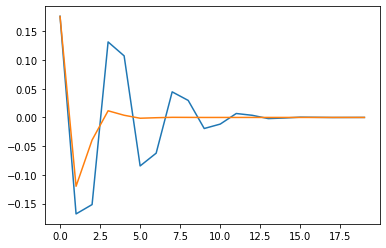

In [6]:
plt.plot(xc)
plt.plot(xk)

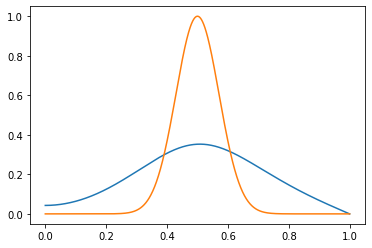

In [7]:
xf = sim.BasisChangeInv(xk)        
plt.plot(t,xf)
plt.plot(t,x)

### Etape 3 : definir modele pour gaussienne

In [8]:
mymodel = MyModel(sim,200)

In [9]:
x0 = torch.FloatTensor(np.zeros((1,1,m))).detach()
xb = torch.FloatTensor(y.reshape(1,1,-1)).detach()

In [10]:
xt = mymodel(x0,xb).detach()

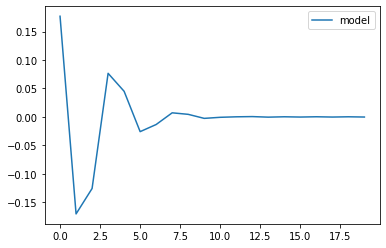

In [11]:
#plt.plot(xc,label="gauss")
plt.plot(xt[0,0].numpy(),label="model")
plt.legend()

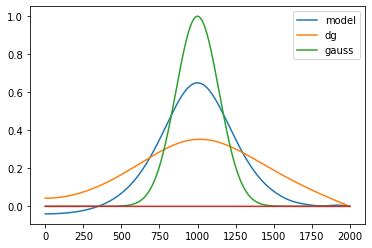

In [12]:
plt.plot(sim.BasisChangeInv(xt[0,0].numpy()),label="model")
plt.plot(xf,label = "dg")
plt.plot(x,label="gauss")
plt.plot(np.zeros(nx))
plt.legend()

### ANNEXE

In [26]:
mymodel = MyModel(sim,200)

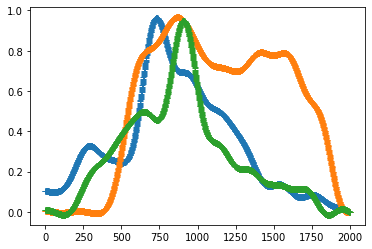

In [27]:
for i,minibatch in enumerate(train_set):
    if i<3:
        [x_init, x_true] = minibatch    # get the minibatch
#         y  = sim.BasisChangeInv(x_init[0,0].numpy())
#         plt.plot(y)        
        y  = sim.BasisChangeInv(x_true[0,0].numpy())
        plt.plot(y,'+')

In [28]:
x_init.shape

torch.Size([5, 1, 20])

In [29]:
x_true.shape

torch.Size([5, 1, 20])

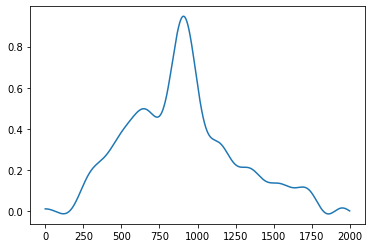

In [30]:
y  = sim.BasisChangeInv(x_true[0,0].numpy())
plt.plot(y)

In [31]:
x_test = mymodel(x_init,x_init).detach()

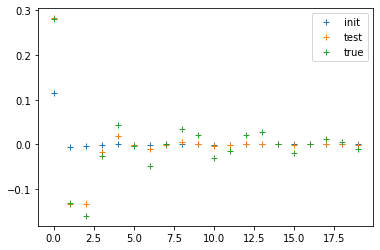

In [32]:
plt.plot(x_init[0,0].numpy(),'+',label='init')
plt.plot(x_test[0,0].numpy(),'+',label='test')
plt.plot(x_true[0,0].numpy(),'+',label ='true')
plt.legend()

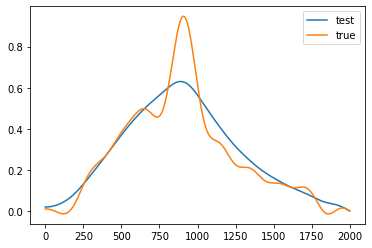

In [33]:
xi_elt = sim.BasisChangeInv(x_init[0,0].numpy())
xt_elt = sim.BasisChangeInv(x_test[0,0].numpy())
plt.plot(xt_elt,label='test')
plt.plot(y,label ='true')
plt.legend()

In [34]:
xt_elt.min()

-0.0002161411794880811

In [35]:
y.min()

-0.014835372574144011

Comparaison avec le veritable signal (positif du coup)

In [36]:
dfr = pd.read_csv(folder+'/Signals/data_lisse.csv', sep=',',header=None)
real=dfr.values
real.shape

(600, 2000)

In [37]:
dfl = pd.read_csv(folder+'/Signals/data_lisse_trsf.csv', sep=',',header=None)
lisse=dfl.values
dfb = pd.read_csv(folder+'/Signals/data_tTblurred.csv', sep=',',header=None)
blurred = torch.FloatTensor(dfb.values[12].reshape(1,1,-1))
test = sim.BasisChangeInv(mymodel(blurred,blurred).detach())

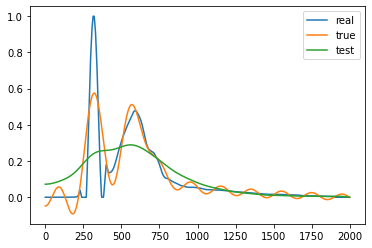

In [38]:
plt.plot(real[12],label='real')
plt.plot(sim.BasisChangeInv(lisse[12]),label='true')
plt.plot(test[0,0].numpy(),label='test')
plt.legend()